In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai

In [4]:
from lib.utils_ import powerset

In [5]:
from importlib import reload

In [6]:
from sklearn.datasets import load_boston

In [7]:
from copy import deepcopy, copy

# Load Data

In [8]:
real_feats = ['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'balance']
cat_feats  = ['job', 'marital', 'education', 'contact', 'month', 'poutcome','day']

In [9]:
bank_ds = pd.read_csv('bank_ds_new.csv', index_col=0)
bank_ds.index = bank_ds.index.astype(str)

In [10]:
with open('bank_ds_test_indexes.txt','r') as f:
    test_idxs = f.read().split(',')

In [11]:
ds = bank_ds.loc[test_idxs]
print(ds.shape)
ds.head()

(1131, 18)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,preds
2398,51,entrepreneur,married,secondary,1,-2082,0,1,cellular,28,jul,123,6,NaN,0,unknown,0,0
800,50,management,married,tertiary,0,2881,0,0,cellular,5,aug,510,2,2.0,5,other,0,0
2288,50,technician,married,secondary,0,1412,0,0,cellular,6,aug,131,3,NaN,0,unknown,0,0
2344,37,management,married,tertiary,0,0,1,0,unknown,3,jun,247,13,NaN,0,unknown,0,0
3615,31,admin.,single,secondary,0,757,0,0,cellular,3,feb,343,2,NaN,0,unknown,0,0


In [12]:
ds[cat_feats] = ds[cat_feats].astype(str)

In [13]:
ds['pdays'] = ds['pdays'].fillna(871)

# Load models

catboost

In [14]:
from catboost import Pool, CatBoostClassifier

In [15]:
cb = CatBoostClassifier()
cb = cb.load_model('cb_bank_2020.06.06.model')

In [16]:
cb.get_feature_importance()

array([ 7.95808012,  6.34549914,  5.46397635,  8.3238347 , 14.35982366,
        7.56982086, 17.14405815,  7.68787232,  1.05184627,  1.80842178,
        1.7629346 ,  2.77146939,  4.07168   ,  2.35346895, 11.32721371])

svc

In [17]:
from sklearn.svm import SVC

In [18]:
import pickle

In [19]:
ds_ohe = ds.copy()
train_cols = real_feats.copy()
for f in cat_feats:
    for v in sorted(ds_ohe[f].unique()):
        ds_ohe[f"{f}__{v}"] = (ds_ohe[f]==v).astype(int)
        train_cols.append(f"{f}__{v}")
    ds_ohe = ds_ohe.drop(f,1)

In [20]:
train_cols_ohe = 'age,default,housing,loan,campaign,pdays,previous,balance,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,job__self-employed,job__services,job__student,job__technician,job__unemployed,job__unknown,marital__divorced,marital__married,marital__single,education__primary,education__secondary,education__tertiary,education__unknown,contact__cellular,contact__telephone,contact__unknown,month__apr,month__aug,month__dec,month__feb,month__jan,month__jul,month__jun,month__mar,month__may,month__nov,month__oct,month__sep,poutcome__failure,poutcome__other,poutcome__success,poutcome__unknown,day__1,day__10,day__11,day__12,day__13,day__14,day__15,day__16,day__17,day__18,day__19,day__2,day__20,day__21,day__22,day__23,day__24,day__25,day__26,day__27,day__28,day__29,day__3,day__30,day__31,day__4,day__5,day__6,day__7,day__8,day__9'.split(',')
ds_ohe = ds_ohe[train_cols_ohe]

In [21]:
ds_ohe['pdays'] = ds_ohe['pdays'].fillna(871)

In [22]:
with open('svc_bank_2020.06.06.pickle', 'rb') as f:
    svc = pickle.load(f)

In [23]:
svc.predict(ds_ohe)

array([0, 0, 0, ..., 0, 0, 0])

NN

In [24]:
from tensorflow import keras

In [25]:
model = keras.models.load_model('nn_bank_2020.06.06.pickle',)

In [26]:
pd.Series(model.predict_classes(ds_ohe).flatten()).value_counts()

0    1127
1       4
dtype: int64

In [27]:
preds_ds = pd.read_csv(DATASETS_DIR+'/bank_ds_preds_2020.06.06.csv', index_col=0)
preds_ds.index = preds_ds.index.astype(str)

In [28]:
ds_ohe_norm = ds_ohe.copy()
ds_ohe_norm = (ds_ohe_norm - ds_ohe_norm.min())/(ds_ohe_norm.max()-ds_ohe_norm.min())

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
ds_le = ds[cat_feats+real_feats]
for f in cat_feats:
    le = LabelEncoder()
    ds_le[f] = le.fit_transform(ds_le[f])

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
ds_le['pdays'] = ds_le['pdays'].fillna(871)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Load pattern structures

In [32]:
[x for x in os.listdir(RESULTS_DIR) if 'bank' in x]

['bank__class0_03.06.20_20:55.json',
 'bank__byrf_13.07.20_14:24.json',
 'bank__class1_04.06.20_07:01.json',
 'bank__class0_04.06.20_07:00.json',
 'bank__class1_03.06.20_20:55.json']

In [33]:
import json

In [34]:
with open(RESULTS_DIR+'/bank__byrf_13.07.20_14:24.json','r') as f:
    ps_bank = json.load(f)

In [35]:
fcai = reload(fcai)

In [36]:
mvcntx = fcai.MultiValuedContext(ds[cat_feats+real_feats], cat_attrs=cat_feats, y_true=ds['y'].astype(np.float32))
fm = fcai.FormalManager(mvcntx)

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Сравнение

## Внутри каждой конкретной итерации кросс валидации

In [38]:
ds.shape

(1131, 18)

In [39]:
train_idxs_cv = ds.index[:1000]
test_idxs_cv = ds.index[1000:]

In [40]:
ds_train = ds.loc[train_idxs_cv]
ds_test = ds.loc[test_idxs_cv]

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Модели для сравнения:
* Logistic regression
* Decision Tree small
* Decision Tree full
* GAM (?)
* 

Что сравниваем:
* Feature Importance
* Качество предсказаний на обучающей выборке
* Качество предсказаний на тестовой выборке
* Качество предсказаний предсказаний модели на обучающей выборке
* Качество предсказаний предсказаний модели на тестовой выборке

Сравнение проводим для каждого чёрного ящика:
* CatBoost
* SVC
* Neural Network

In [42]:
bb_types = ['cb','nn']

In [43]:
from sklearn.metrics import f1_score

In [44]:
def get_fimps_cb(ds_train, cb):
    sv = cb.get_feature_importance(Pool(ds_train[cat_feats+real_feats], cat_features=cat_feats), 'ShapValues')
    sv_ds = pd.DataFrame(sv, columns=cat_feats+real_feats+['bias']).drop('bias',1)
    fimps_sv = sv_ds.abs().median().sort_values(ascending=False)
    return fimps_sv

In [45]:
def get_fimps_nn(ds_train, model):
    explainer = shap.DeepExplainer(model, ds_train.values)
    sv = explainer.shap_values(ds_train.values)[0]
    sv_ds = pd.DataFrame(sv, columns=ds_train.columns)
    
    fimps_sv = sv_ds.abs().median().reset_index()
    fimps_sv.columns = ['feature_ohe','sv']
    fimps_sv['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_sv['feature_ohe']]
    fimps_sv['sv_abs'] = fimps_sv['sv'].abs()
    fimps_sv = fimps_sv.groupby('feature')['sv_abs'].sum()
    #fimps_sv.sort_values(ascending=False)
    return fimps_sv

In [46]:
def get_fimps_svc(ds_train, svc, k=10, nsamples=10):
    svds = shap.kmeans(ds_train, k)
    explainer =shap.KernelExplainer(svc.predict, svds)
    sv = explainer.shap_values(ds_train.values, nsamples=nsamples)
    
    sv_ds = pd.DataFrame(sv, columns=ds_train.columns)

    fimps_sv = sv_ds.abs().median().reset_index()
    fimps_sv.columns = ['feature_ohe','sv']
    fimps_sv['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_sv['feature_ohe']]
    fimps_sv['sv_abs'] = fimps_sv['sv'].abs()
    fimps_sv = fimps_sv.groupby('feature')['sv_abs'].sum()
    return fimps_sv

In [47]:
def get_fimps_lr(ds_train, lr):
    fimps_lr = pd.Series(lr.coef_[0], index=ds_train.columns).reset_index()
    fimps_lr.columns = ['feature_ohe','sv']
    fimps_lr['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_lr['feature_ohe']]
    fimps_lr['sv_abs'] = fimps_lr['sv'].abs()
    fimps_lr = fimps_lr.groupby('feature')['sv_abs'].sum()
    return fimps_lr

In [48]:
preds_ds['y'] = ds['y']

In [49]:
def test_lr(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    stat = {}
    
    lr = LogisticRegression()
    lr.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, 'y'])
    preds_test_real = lr.predict(ds.loc[test_idxs_cv])
    stat[f"acc_test_real_lr"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_lr"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        lr = LogisticRegression()
        lr.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f'preds_{bb_type}'])
        preds_train_bb = lr.predict(ds.loc[train_idxs_cv])
        preds_test_bb = lr.predict(ds.loc[test_idxs_cv])

        stat[f"{bb_type}_acc_train_bb_lr"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_lr"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_lr"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_lr"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        
        stat[f"{bb_type}_lr_fimps"] =  get_fimps_lr(ds, lr)
    
    return stat

In [50]:
def test_dts(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    dt_small = DecisionTreeClassifier(max_depth=5)
    dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv,'y'])
    preds_test_real = dt_small.predict(ds.loc[test_idxs_cv])
    stat = {}
    stat[f"acc_test_real_dts"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_dts"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        dt_small = DecisionTreeClassifier(max_depth=5)
        dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f"preds_{bb_type}"])
        preds_train_bb = dt_small.predict(ds.loc[train_idxs_cv])
        preds_test_bb = dt_small.predict(ds.loc[test_idxs_cv])

        fimps_dts = pd.Series(dt_small.feature_importances_, index=ds.columns)

        stat[f"{bb_type}_acc_train_bb_dts"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_dts"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_dts"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_dts"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_dts_fimps"] = fimps_dts
    return stat

In [51]:
def test_dtl(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    dt_small = DecisionTreeClassifier()
    dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv,'y'])
    preds_test_real = dt_small.predict(ds.loc[test_idxs_cv])
    stat = {}
    stat[f"acc_test_real_dtl"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_dtl"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        dt_small = DecisionTreeClassifier()
        dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f"preds_{bb_type}"])
        preds_train_bb = dt_small.predict(ds.loc[train_idxs_cv])
        preds_test_bb = dt_small.predict(ds.loc[test_idxs_cv])

        fimps_dts = pd.Series(dt_small.feature_importances_, index=ds.columns)

        stat[f"{bb_type}_acc_train_bb_dtl"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_dtl"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_dtl"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_dtl"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_dtl_fimps"] = fimps_dts
    return stat

In [91]:
fm.get_context()

Num of objects: 1131, Num of attrs: 15
Objects (len: 1131): 2398, 800, 2288, 2344, 3615,...
Attrs (len: 15): job, marital, education, contact, month,...

In [195]:
def test_fca_full(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
    
    fm_cv.construct_lattice(only_spanning_tree=True)
    if verb:
        print('construct lattice')
    for c in fm_cv.get_concepts():
        ext_ =  fm_cv.get_context().get_objs()[c.get_extent()]
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].mean()
        
    if verb:
        print('recalc metrics')
    
    preds_train_real = fm_cv.predict_context(mvcntx_train, metric='mean_y_true')[:,0].flatten()
    preds_train_real = pd.Series(preds_train_real).fillna(fm_cv._top_concept._metrics['mean_y_true']).values
    
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric='mean_y_true')[:,0].flatten()
    preds_test_real = pd.Series(preds_test_real).fillna(fm_cv._top_concept._metrics['mean_y_true']).values
    ths = np.linspace(0,1,101)
    accs = [f1_score(preds_ds.loc[train_idxs_cv, 'y'], preds_train_real>t) for t in ths]
    t = ths[np.argmax(accs)]
    preds_test_real = (preds_test_real>=t).astype(int)
    
    if verb:
        print('pred test real')
    
    stat = {}
    stat[f"acc_test_real_fcafull"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_fcafull"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    
    
    
    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        #print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
        fm_cv.construct_lattice(only_spanning_tree=True)
        for c in fm_cv.get_concepts():
            ext_ =  fm_cv.get_context().get_objs()[c.get_extent()]
            c._metrics[f'mean_y_preds_{bb_type}'] = preds_ds.loc[ext_, f'preds_{bb_type}'].mean()
        
        
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=f"mean_y_preds_{bb_type}")[:,0].flatten()
        if verb:
            print(f'pred {bb_type} train')
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=f"mean_y_preds_{bb_type}")[:,0].flatten()
        if verb:
            print(f'pred {bb_type} test')

        preds_train_bb = pd.Series(preds_train_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        preds_test_bb = pd.Series(preds_test_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        
        accs = [f1_score(preds_ds.loc[train_idxs_cv, f"preds_{bb_type}"], preds_train_bb>t) for t in ths]
        t = ths[np.argmax(accs)]
        
        preds_train_bb = (preds_train_bb>=t).astype(int)
        preds_test_bb = (preds_test_bb>=t).astype(int)

        metric_difference = fm_cv.get_metric_difference(f'mean_y_preds_{bb_type}')
        fimps_fca = {k:np.sum(np.abs(v)) for k,v in metric_difference.items()}
        if verb:
            print(f"calc {bb_type} fimps")

        stat[f"{bb_type}_acc_train_bb_fcafull"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcafull"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_fcafull"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_fcafull"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_fcafull_fimps"] = fimps_fca
    return stat

In [100]:
def test_fca_stable(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
    
    fm_cv.construct_lattice()
    fm_cv.calc_stability_approx()
    concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
    fm_cv.set_concepts(concepts_stab)
    fm_cv.construct_lattice()
    
    if verb:
        print(f'construct lattice, n_concepts: {len(fm_cv.get_concepts())}')
    for c in fm_cv.get_concepts():
        ext_ = c.get_extent()
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].mean()
        
    if verb:
        print('recalc metrics')
            
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric='mean_y_true')
    preds_test_real = pd.Series(preds_test_real).fillna(fm_cv._top_concept._metrics['mean_y_true']).values
    preds_test_real = (preds_test_real>=0.5).astype(int)
    if verb:
        print('pred test real')
    
    stat = {}
    stat[f"acc_test_real_fcastab"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_fcastab"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    
    
    
    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        #print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
        fm_cv.construct_lattice()
        fm_cv.calc_stability_approx()
        concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
        fm_cv.set_concepts(concepts_stab)
        fm_cv.construct_lattice()
        
        for c in fm_cv.get_concepts():
            ext_ = c.get_extent()
            c._metrics[f'mean_y_preds_{bb_type}'] = preds_ds.loc[ext_, f'preds_{bb_type}'].mean()
        
        
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=f"mean_y_preds_{bb_type}")
        if verb:
            print(f'pred {bb_type} train')
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=f"mean_y_preds_{bb_type}")
        if verb:
            print(f'pred {bb_type} test')

        preds_train_bb = pd.Series(preds_train_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        preds_test_bb = pd.Series(preds_test_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        
        preds_train_bb = (preds_train_bb>=0.5).astype(int)
        preds_test_bb = (preds_test_bb>=0.5).astype(int)

        metric_difference = fm_cv.get_metric_difference(f'mean_y_preds_{bb_type}')
        fimps_fca = {k:np.sum(np.abs(v)) for k,v in metric_difference.items()}
        if verb:
            print(f"calc {bb_type} fimps")

        stat[f"{bb_type}_acc_train_bb_fcastab"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcastab"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_fcastab"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_fcastab"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        
        stat[f"{bb_type}_fcastab_fimps"] = fimps_fca
    return stat

In [94]:
def test_fca_stable_strong_min(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
    
    fm_cv.construct_lattice()
    fm_cv.calc_stability_approx()
    concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
    fm_cv.set_concepts(concepts_stab)
    fm_cv.construct_lattice()
    
    if verb:
        print(f'construct lattice, n_concepts: {len(fm_cv.get_concepts())}')
    for c in fm_cv.get_concepts():
        ext_ = c.get_extent()
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].mean()
            
    if verb:
        print('recalc metrics')
        
    concepts_stab = deepcopy(fm_cv.get_concepts())
    for c in concepts_stab:
        c._metrics['strongness'] = abs(c._metrics['mean_y_true']-0.5)+0.5
    concepts_strong = fm_cv.select_smallest_covering_hyps([c for c in concepts_stab if c._metrics['strongness']>=0.6], use_tqdm=False)
    print(f'num of strong hyps for test real: {len(concepts_strong)}')
    fm_cv.set_concepts(concepts_strong)
    fm_cv.construct_lattice()
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric='mean_y_true')
    preds_test_real = pd.Series(preds_test_real).fillna(fm_cv._top_concept._metrics['mean_y_true']).values
    
    preds_test_real = (preds_test_real>=0.5).astype(int)
    if verb:
        print('pred test real')
    
    stat = {}
    stat[f"acc_test_real_fcastab_min"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    stat[f"f1_test_real_fcastab_min"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    
    
    
    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        #print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS)
        fm_cv.construct_lattice()
        fm_cv.calc_stability_approx()
        concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
        fm_cv.set_concepts(concepts_stab)
        fm_cv.construct_lattice()
        
        for c in fm_cv.get_concepts():
            ext_ = c.get_extent()
            c._metrics[f'mean_y_preds_{bb_type}'] = preds_ds.loc[ext_, f'preds_{bb_type}'].mean()
        
        concepts_stab = deepcopy(fm_cv.get_concepts())
        for c in concepts_stab:
            c._metrics['strongness'] = abs(c._metrics[f'mean_y_preds_{bb_type}']-0.5)+0.5
        concepts_strong = fm_cv.select_smallest_covering_hyps([c for c in concepts_stab if c._metrics['strongness']>=0.6], use_tqdm=False)
        
        print(f'num of strong hyps for test real: {len(concepts_strong)}')
        fm_cv.set_concepts(concepts_strong)
        fm_cv.construct_lattice()
        
        
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=f"mean_y_preds_{bb_type}")
        if verb:
            print(f'pred {bb_type} train')
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=f"mean_y_preds_{bb_type}")
        if verb:
            print(f'pred {bb_type} test')

        preds_train_bb = pd.Series(preds_train_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        preds_test_bb = pd.Series(preds_test_bb).fillna(fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}']).values
        
        preds_train_bb = (preds_train_bb>=0.5).astype(int)
        preds_test_bb = (preds_test_bb>=0.5).astype(int)

        metric_difference = fm_cv.get_metric_difference(f'mean_y_preds_{bb_type}')
        fimps_fca = {k:np.sum(np.abs(v)) for k,v in metric_difference.items()}
        if verb:
            print(f"calc {bb_type} fimps")

        stat[f"{bb_type}_acc_train_bb_fcastab_min"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcastab_min"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_f1_train_bb_fcastab_min"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_f1_test_bb_fcastab_min"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        stat[f"{bb_type}_fcastab_min_fimps"] = fimps_fca
    return stat

In [95]:
import shap

In [176]:
RF_PARAMS = {'n_estimators':100, 'max_depth':None, 'random_state':42}

In [196]:
stat = {}

In [197]:
stat['cb_fimps_sv'] = get_fimps_cb(ds_train, cb)

In [198]:
stat['nn_fimps_sv'] = get_fimps_nn(ds_ohe.loc[train_idxs_cv], model)

In [199]:
stat['svc_fimps_sv'] = get_fimps_svc(ds_ohe.loc[train_idxs_cv], svc, k=2)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

In [200]:
stat_lr = test_lr(ds_ohe_norm, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
stat = dict(stat, **stat_lr)

In [201]:
stat_dts = test_dts(ds_le, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
stat = dict(stat, **stat_dts)

In [202]:
stat_dtl = test_dtl(ds_le, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
stat = dict(stat, **stat_dtl)

In [203]:
%%time
stat_fca_full = test_fca_full(mvcntx, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
stat = dict(stat, **stat_fca_full)

modified contexts: train_size=1000, test_size=131
1000 (1000, 15) 1000



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
CPU times: user 2min 6s, sys: 1.19 s, total: 2min 7s
Wall time: 2min 4s


In [204]:
stat_ds = pd.DataFrame([stat])

In [205]:
stat_ds

,cb_fimps_sv,nn_fimps_sv,svc_fimps_sv,acc_test_real_lr,f1_test_real_lr,cb_acc_train_bb_lr,cb_acc_test_bb_lr,cb_f1_train_bb_lr,cb_f1_test_bb_lr,cb_lr_fimps,...,cb_acc_train_bb_fcafull,cb_acc_test_bb_fcafull,cb_f1_train_bb_fcafull,cb_f1_test_bb_fcafull,cb_fcafull_fimps,nn_acc_train_bb_fcafull,nn_acc_test_bb_fcafull,nn_f1_train_bb_fcafull,nn_f1_test_bb_fcafull,nn_fcafull_fimps
0,pdays 0.900574 contact 0.197572 mo...,feature age 0.000044 balance 0.0...,feature age 0.0 balance 0.0 camp...,0.916031,0.352941,0.979,0.969466,0.603774,0.5,feature age 0.965777 balance 0...,...,0.981,0.954198,0.641509,0.0,{},1.0,0.992366,1.0,0.0,{}


In [206]:
stat_ds_mean = stat_ds.mean()

In [207]:
stat_ds_mean_ds = stat_ds_mean.reset_index()
stat_ds_mean_ds.columns = ['stat','value']
stat_ds_mean_ds.head()

,stat,value
0,acc_test_real_lr,0.916031
1,f1_test_real_lr,0.352941
2,cb_acc_train_bb_lr,0.979000
3,cb_acc_test_bb_lr,0.969466
4,cb_f1_train_bb_lr,0.603774


In [208]:
stat_ds_mean_ds

,stat,value
0,acc_test_real_lr,0.916031
1,f1_test_real_lr,0.352941
2,cb_acc_train_bb_lr,0.979000
3,cb_acc_test_bb_lr,0.969466
4,cb_f1_train_bb_lr,0.603774
5,cb_f1_test_bb_lr,0.500000
6,nn_acc_train_bb_lr,0.997000
7,nn_acc_test_bb_lr,0.992366
8,nn_f1_train_bb_lr,0.000000
9,nn_f1_test_bb_lr,0.000000


In [209]:
import re

In [210]:
stat_ds_mean_ds['bb_type'] = [[bb_type for bb_type in bb_types+['real']
                               if bb_type in x][0] for x in stat_ds_mean_ds['stat']]
#stat_ds_mean_ds['interp_type'] = [[interp_type for interp_type in ['lr','dts','dtl','fcafull','fcastab','fcastab_min']
        #if x.endswith(interp_type)][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['interp_type'] = [[interp_type for interp_type in ['lr','dts','dtl','fcafull']
                                   if x.endswith(interp_type)][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['ds_type'] = [[ds_type for ds_type in ['train','test'] if ds_type in x][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['metric'] = ['acc' if 'acc' in x else 'f1_' if 'f1_' in x else None for x in stat_ds_mean_ds['stat']]

In [211]:
cds = stat_ds_mean_ds.pivot_table(index=['interp_type','metric'], columns=['bb_type','ds_type'], values='value')

In [212]:
#cds = cds.loc[['lr','dts','dtl','fcafull','fcastab','fcastab_min']]
cds = cds.loc[['lr','dts','dtl','fcafull']]

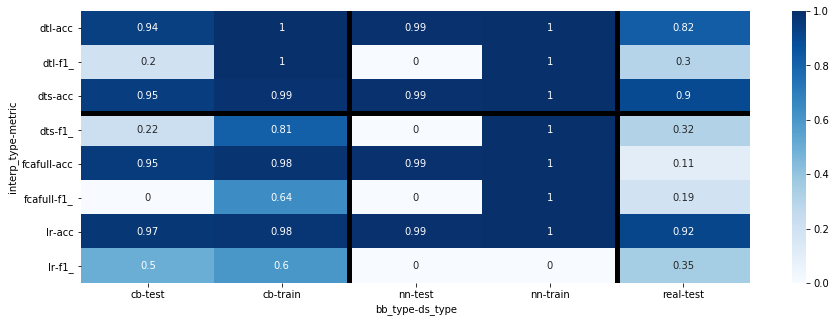

In [213]:
plt.figure(figsize=(15,5))
sns.heatmap(cds, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.axhline(3, color='black', linewidth=5)
for x in [2,4]:
    plt.axvline(x, color='black', linewidth=5)

In [169]:
stat_ds[[x for x in stat_ds.columns if 'fimps' in x]]

,cb_fimps_sv,nn_fimps_sv,svc_fimps_sv,cb_lr_fimps,nn_lr_fimps,cb_dts_fimps,nn_dts_fimps,cb_dtl_fimps,nn_dtl_fimps,cb_fcafull_fimps,nn_fcafull_fimps,cb_fcastab_fimps,nn_fcastab_fimps,cb_fcastab_min_fimps,nn_fcastab_min_fimps
0,pdays 0.900574 contact 0.197572 mo...,feature age 0.000044 balance 0.0...,feature age 0.0 balance 0.0 camp...,feature age 0.965777 balance 0...,feature age 0.348501 balance 0.0...,job 0.034741 marital 0.000000 ed...,job 0.269061 marital 0.000000 ed...,job 0.024643 marital 0.000000 ed...,job 0.310455 marital 0.000000 ed...,"{'month': 35.74867703722573, 'campaign': 27.31...","{'job': 3.1438963132776236, 'age': 2.990810289...","{'job': 0.08860992607777313, 'marital': 0.0126...","{'contact': 0.23861902289095727, 'month': 0.32...",{},{}


In [170]:
from scipy.stats import spearmanr

In [171]:
fimps_cols = [x for x in stat.keys() if 'fimps' in x]
fimps_cols

['cb_fimps_sv',
 'nn_fimps_sv',
 'svc_fimps_sv',
 'cb_lr_fimps',
 'nn_lr_fimps',
 'cb_dts_fimps',
 'nn_dts_fimps',
 'cb_dtl_fimps',
 'nn_dtl_fimps',
 'cb_fcafull_fimps',
 'nn_fcafull_fimps',
 'cb_fcastab_fimps',
 'nn_fcastab_fimps',
 'cb_fcastab_min_fimps',
 'nn_fcastab_min_fimps']

In [172]:
corrs = []
for x1 in fimps_cols:
    for x2 in fimps_cols:
        #print(x1, x2)
        r1 = pd.Series(stat[x1]).sort_index()
        r2 = pd.Series(stat[x2]).sort_index()
        for k in set(r2.index)-set(r1.index):
            r1[k] = 0
        for k in set(r1.index)-set(r2.index):
            r2[k] = 0
        
        corr = spearmanr(r1.values, r2.values).correlation
        corrs.append((x1,x2,corr))

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [173]:
corrs_ds = pd.DataFrame(corrs, columns=['interp_1', 'interp_2', 'corr'])
corrs_ds

,interp_1,interp_2,corr
0,cb_fimps_sv,cb_fimps_sv,1.000000
1,cb_fimps_sv,nn_fimps_sv,0.553571
2,cb_fimps_sv,svc_fimps_sv,NaN
3,cb_fimps_sv,cb_lr_fimps,0.100000
4,cb_fimps_sv,nn_lr_fimps,0.364286
...,...,...,...
220,nn_fcastab_min_fimps,nn_fcafull_fimps,NaN
221,nn_fcastab_min_fimps,cb_fcastab_fimps,NaN
222,nn_fcastab_min_fimps,nn_fcastab_fimps,NaN
223,nn_fcastab_min_fimps,cb_fcastab_min_fimps,NaN


In [174]:
cds = corrs_ds.pivot_table(index='interp_1', columns='interp_2', values='corr', aggfunc='mean')

In [175]:
cds1 = cds.loc[sorted([x for x in cds.index if 'cb' in x]), sorted([x for x in cds.index if 'cb' in x])]
cds2 = cds.loc[sorted([x for x in cds.index if 'nn' in x]), sorted([x for x in cds.index if 'nn' in x])]

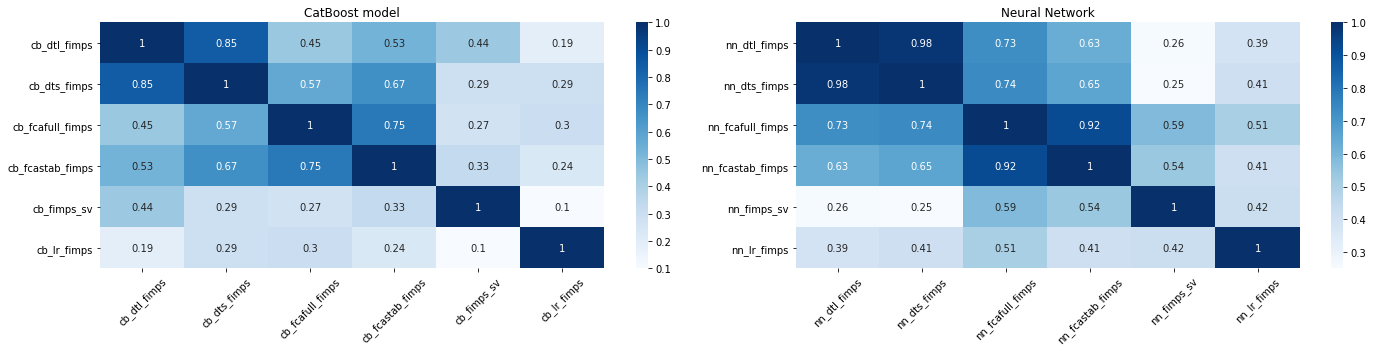

In [176]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.heatmap(cds1, cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.title('CatBoost model')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1,2,2)
sns.heatmap(cds2, cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.title('Neural Network')
plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

## Cross Validation Real

In [179]:
from sklearn.model_selection import KFold

In [180]:
kf = KFold(10)

In [181]:
stats = []

In [196]:
for train_idxs_cv_i, test_idxs_cv_i in tqdm(kf.split(ds), total=kf.get_n_splits()):
    #continue
    train_idxs_cv = ds.index[train_idxs_cv_i]
    test_idxs_cv = ds.index[test_idxs_cv_i]
    
    ds_train = ds.loc[train_idxs_cv]
    ds_test = ds.loc[test_idxs_cv]
    
    stat = {}
    stat['cb_fimps_sv'] = get_fimps_cb(ds_train, cb)
    stat['nn_fimps_sv'] = get_fimps_nn(ds_ohe.loc[train_idxs_cv], model)
    stat['svc_fimps_sv'] = get_fimps_svc(ds_ohe.loc[train_idxs_cv], svc, k=2)

    stat_lr = test_lr(ds_ohe_norm, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_lr)

    stat_dts = test_dts(ds_le, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_dts)

    stat_dtl = test_dtl(ds_le, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_dtl)

    stat_fca_full = test_fca_full(mvcntx, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_full)

    stat_fca_stab = test_fca_stable(mvcntx, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_stab)
    
    stat_fca_stab_min = test_fca_stable_strong_min(mvcntx, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_stab_min)
    
    stats.append(stat)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


modified contexts: train_size=1017, test_size=114
1017 (1017, 15) 1017



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1017, test_size=114
1017 (1017, 15) 1017


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1017, test_size=114
1017 (1017, 15) 1017


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 3
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 4
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 4
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 2
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 4
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 4
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 2
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 3
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 3
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 3
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 3
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 5
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018



construct lattice
recalc metrics
pred test real



pred cb train
pred cb test
calc cb fimps



pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


pred nn train
pred nn test
calc nn fimps
modified contexts: train_size=1018, test_size=113
1018 (1018, 15) 1018


divide by zero encountered in log2
divide by zero encountered in log2


construct lattice, n_concepts: 50
recalc metrics
num of strong hyps for test real: 4
pred test real


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 3
pred cb train
pred cb test
calc cb fimps


divide by zero encountered in log2
divide by zero encountered in log2


num of strong hyps for test real: 1
pred nn train
pred nn test
calc nn fimps



In [197]:
stat_ds = pd.DataFrame(stats)

In [198]:
stat_ds.to_csv(RESULTS_DIR+'/stat_ds_14.07.2020.csv')

In [199]:
stat_ds_mean = stat_ds[[x for x  in stat_ds if 'fimps' not in x]].mean()

In [200]:
stat_ds_mean_ds = stat_ds_mean.reset_index()
stat_ds_mean_ds.columns = ['stat','value']
stat_ds_mean_ds.head()

,stat,value
0,acc_test_real_lr,0.894760
1,f1_test_real_lr,0.172664
2,cb_acc_train_bb_lr,0.979566
3,cb_acc_test_bb_lr,0.971697
4,cb_f1_train_bb_lr,0.623570


In [201]:
import re

In [202]:
stat_ds_mean_ds['bb_type'] = [[bb_type for bb_type in bb_types+['real'] if bb_type in x][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['interp_type'] = [[interp_type for interp_type in ['lr','dts','dtl','fcafull','fcastab','fcastab_min'] if x.endswith(interp_type)][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['ds_type'] = [[ds_type for ds_type in ['train','test'] if ds_type in x][0] for x in stat_ds_mean_ds['stat']]

In [203]:
colsmap = {'lr':'LogRegression','dts':'DecisionTree depth5', 'dtl':'DecisionTree maxdepth', 'fcafull':'FCA all concepts',
                              'fcastab':'FCA 100 most stable concepts', 'fcastab_min':'FCA strong stable concepts',
           'cb':'CatBoost','nn':'NeuralNetwork','svc':'SVM'
       }

In [204]:
stat_ds_mean_ds_acc = stat_ds_mean_ds.loc[['acc' in x for x in stat_ds_mean_ds['stat']]]
stat_ds_mean_ds_f1 = stat_ds_mean_ds.loc[['f1' in x for x in stat_ds_mean_ds['stat']]]

In [205]:
stat_ds_mean_ds_f1.shape, stat_ds_mean_ds_acc.shape

((30, 5), (30, 5))

In [206]:
cds = stat_ds_mean_ds_acc.pivot_table(index='interp_type', columns=['bb_type','ds_type'], values='value')
cds = cds.loc[['lr','dts','dtl','fcafull','fcastab','fcastab_min']]
cds.columns = ['-'.join(x) for x in cds.columns]
cds.columns = [x.replace('cb','CatBoost').replace('nn','NeuralNetwork').replace('svc','SVM').replace('-test',' Test').replace('-train',' Train') for x in cds.columns]
cds = cds.rename({'lr':'LogRegression','dts':'DecisionTree depth5', 'dtl':'DecisionTree maxdepth', 'fcafull':'FCA all concepts',
                              'fcastab':'FCA 100 most stable concepts', 'fcastab_min':'FCA strong stable concepts'})
cds = cds[['CatBoost Train','CatBoost Test', 'NeuralNetwork Train',  'NeuralNetwork Test', 'real Test']]

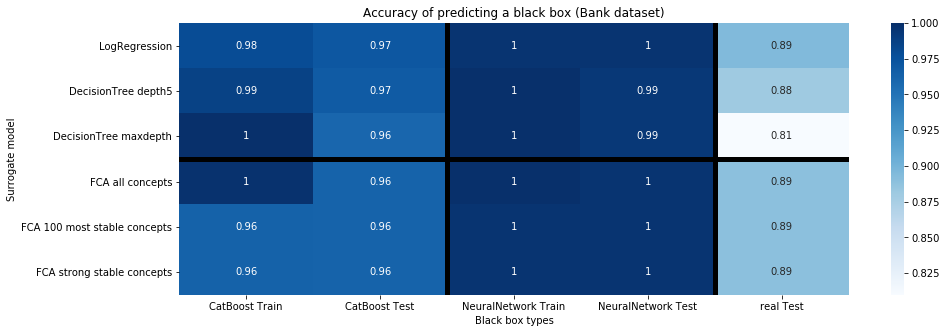

In [207]:
plt.figure(figsize=(15,5))
sns.heatmap(cds, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.axhline(3, color='black', linewidth=5)
for x in [2,4]:
    plt.axvline(x, color='black', linewidth=5)
plt.title('Accuracy of predicting a black box (Bank dataset)')
plt.xlabel('Black box types')
plt.ylabel('Surrogate model')
plt.show()

In [209]:
cds.round(4)

,CatBoost Train,CatBoost Test,NeuralNetwork Train,NeuralNetwork Test,real Test
interp_type,,,,,
LogRegression,0.9796,0.9717,0.9965,0.9965,0.8948
DecisionTree depth5,0.9869,0.9686,1.0000,0.9934,0.8806
DecisionTree maxdepth,1.0000,0.9602,1.0000,0.9934,0.8099
FCA all concepts,0.9979,0.9629,1.0000,0.9965,0.8895
FCA 100 most stable concepts,0.9629,0.9629,0.9966,0.9965,0.8895
FCA strong stable concepts,0.9629,0.9629,0.9965,0.9965,0.8895


In [210]:
print(cds.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  CatBoost Train &  CatBoost Test &  NeuralNetwork Train &  NeuralNetwork Test &  real Test \\
interp\_type                  &                 &                &                      &                     &            \\
\midrule
LogRegression                &        0.979566 &       0.971697 &             0.996463 &            0.996460 &   0.894760 \\
DecisionTree depth5          &        0.986934 &       0.968592 &             1.000000 &            0.993371 &   0.880624 \\
DecisionTree maxdepth        &        1.000000 &       0.960193 &             1.000000 &            0.993371 &   0.809859 \\
FCA all concepts             &        0.997937 &       0.962863 &             1.000000 &            0.996460 &   0.889474 \\
FCA 100 most stable concepts &        0.962865 &       0.962863 &             0.996561 &            0.996460 &   0.889474 \\
FCA strong stable concepts   &        0.962865 &       0.962863 &             0.996463 &            0.996460

In [211]:
cds = stat_ds_mean_ds_f1.pivot_table(index='interp_type', columns=['bb_type','ds_type'], values='value')
cds = cds.loc[['lr','dts','dtl','fcafull','fcastab','fcastab_min']]
cds.columns = ['-'.join(x) for x in cds.columns]
cds.columns = [x.replace('cb','CatBoost').replace('nn','NeuralNetwork').replace('svc','SVM').replace('-test',' Test').replace('-train',' Train') for x in cds.columns]
cds = cds.rename({'lr':'LogRegression','dts':'DecisionTree depth5', 'dtl':'DecisionTree maxdepth', 'fcafull':'FCA all concepts',
                              'fcastab':'FCA 100 most stable concepts', 'fcastab_min':'FCA strong stable concepts'})
cds = cds[['CatBoost Train','CatBoost Test', 'NeuralNetwork Train',  'NeuralNetwork Test', 'real Test']]

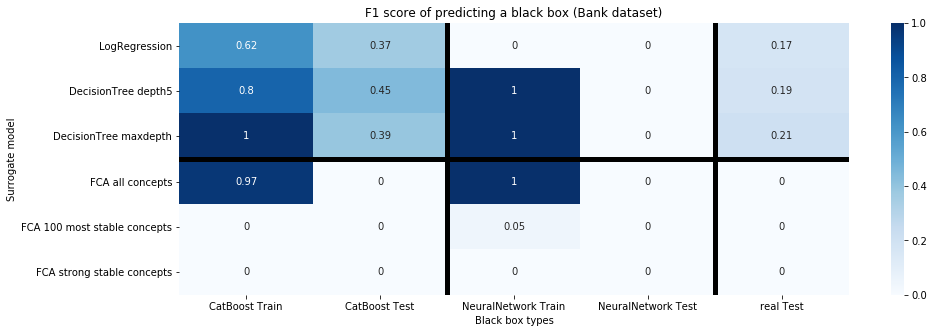

In [212]:
plt.figure(figsize=(15,5))
sns.heatmap(cds, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.axhline(3, color='black', linewidth=5)
for x in [2,4]:
    plt.axvline(x, color='black', linewidth=5)
plt.title('F1 score of predicting a black box (Bank dataset)')
plt.xlabel('Black box types')
plt.ylabel('Surrogate model')
plt.show()

In [213]:
cds

,CatBoost Train,CatBoost Test,NeuralNetwork Train,NeuralNetwork Test,real Test
interp_type,,,,,
LogRegression,0.623570,0.366587,0.00,0.0,0.172664
DecisionTree depth5,0.800453,0.445426,1.00,0.0,0.186683
DecisionTree maxdepth,1.000000,0.391872,1.00,0.0,0.207857
FCA all concepts,0.971181,0.000000,1.00,0.0,0.000000
FCA 100 most stable concepts,0.000000,0.000000,0.05,0.0,0.000000
FCA strong stable concepts,0.000000,0.000000,0.00,0.0,0.000000


In [214]:
from scipy.stats import spearmanr

In [215]:
fimps_cols = [x for x in stat.keys() if 'fimps' in x]
fimps_cols

['cb_fimps_sv',
 'nn_fimps_sv',
 'svc_fimps_sv',
 'cb_lr_fimps',
 'nn_lr_fimps',
 'cb_dts_fimps',
 'nn_dts_fimps',
 'cb_dtl_fimps',
 'nn_dtl_fimps',
 'cb_fcafull_fimps',
 'nn_fcafull_fimps',
 'cb_fcastab_fimps',
 'nn_fcastab_fimps',
 'cb_fcastab_min_fimps',
 'nn_fcastab_min_fimps']

In [216]:
cds1s = []
cds2s = []
for stat in stats:
    corrs = []
    for x1 in fimps_cols:
        for x2 in fimps_cols:
            #print(x1, x2)
            r1 = pd.Series(stat[x1]).sort_index()
            r2 = pd.Series(stat[x2]).sort_index()
            for k in set(r2.index)-set(r1.index):
                r1[k] = 0
            for k in set(r1.index)-set(r2.index):
                r2[k] = 0

            corr = spearmanr(r1.values, r2.values).correlation
            corrs.append((x1,x2,corr))
    corrs_ds = pd.DataFrame(corrs, columns=['interp_1', 'interp_2', 'corr'])
    cds = corrs_ds.pivot_table(index='interp_1', columns='interp_2', values='corr', aggfunc='mean')
    cds1 = cds.loc[sorted([x for x in cds.index if 'cb' in x]), sorted([x for x in cds.index if 'cb' in x])]
    cds2 = cds.loc[sorted([x for x in cds.index if 'nn' in x]), sorted([x for x in cds.index if 'nn' in x])]
    
    cds1s.append(cds1)
    cds2s.append(cds2)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal


KeyError: 'cb_fcafull_fimps'

In [217]:
cds1 = cds1s[0].copy()
for i in range(1, len(cds1s)):
    cds1 += cds1s[i]
cds1 /= 10

IndexError: list index out of range

In [218]:
cds1 = cds1.loc[['cb_lr_fimps','cb_dts_fimps','cb_dtl_fimps','cb_fcafull_fimps','cb_fcastab_fimps','cb_fimps_sv'],
         ['cb_lr_fimps','cb_dts_fimps','cb_dtl_fimps','cb_fcafull_fimps','cb_fcastab_fimps','cb_fimps_sv']]

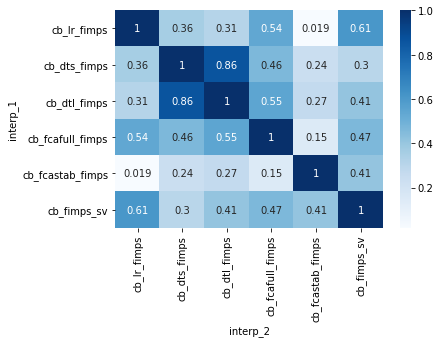

In [1119]:
sns.heatmap(cds1, cmap='Blues', annot=True)

In [1137]:
print(cds1.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
interp\_2 &  cb\_lr\_fimps &  cb\_dts\_fimps &  cb\_dtl\_fimps &  cb\_fcafull\_fimps &  cb\_fcastab\_fimps &  cb\_fimps\_sv \\
interp\_1         &              &               &               &                   &                   &              \\
\midrule
cb\_lr\_fimps      &     1.000000 &      0.361413 &      0.314269 &          0.538571 &          0.018767 &     0.611429 \\
cb\_dts\_fimps     &     0.361413 &      1.000000 &      0.864531 &          0.463817 &          0.241457 &     0.303639 \\
cb\_dtl\_fimps     &     0.314269 &      0.864531 &      1.000000 &          0.549356 &          0.274023 &     0.412598 \\
cb\_fcafull\_fimps &     0.538571 &      0.463817 &      0.549356 &          1.000000 &          0.150670 &     0.465357 \\
cb\_fcastab\_fimps &     0.018767 &      0.241457 &      0.274023 &          0.150670 &          1.000000 &     0.410367 \\
cb\_fimps\_sv      &     0.611429 &      0.303639 &      0.412598 &          0.465357 &

In [1141]:
cds2 = cds2s[0].copy()
for i in range(1, len(cds2s)):
    cds2 += cds2s[i]
cds2 /= 10

In [1143]:
cds2 = cds2.loc[['nn_lr_fimps','nn_dts_fimps','nn_dtl_fimps','nn_fcafull_fimps','nn_fcastab_fimps','nn_fimps_sv'],
         ['nn_lr_fimps','nn_dts_fimps','nn_dtl_fimps','nn_fcafull_fimps','nn_fcastab_fimps','nn_fimps_sv']]

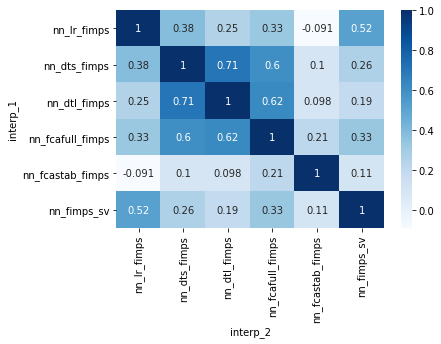

In [1145]:
sns.heatmap(cds2, cmap='Blues', annot=True)

In [1149]:
print(cds2.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
interp\_2 &  nn\_lr\_fimps &  nn\_dts\_fimps &  nn\_dtl\_fimps &  nn\_fcafull\_fimps &  nn\_fcastab\_fimps &  nn\_fimps\_sv \\
interp\_1         &              &               &               &                   &                   &              \\
\midrule
nn\_lr\_fimps      &     1.000000 &      0.378723 &      0.254300 &          0.329580 &         -0.090701 &     0.518214 \\
nn\_dts\_fimps     &     0.378723 &      1.000000 &      0.706875 &          0.600840 &          0.100506 &     0.259607 \\
nn\_dtl\_fimps     &     0.254300 &      0.706875 &      1.000000 &          0.624248 &          0.097737 &     0.186484 \\
nn\_fcafull\_fimps &     0.329580 &      0.600840 &      0.624248 &          1.000000 &          0.212426 &     0.334585 \\
nn\_fcastab\_fimps &    -0.090701 &      0.100506 &      0.097737 &          0.212426 &          1.000000 &     0.107864 \\
nn\_fimps\_sv      &     0.518214 &      0.259607 &      0.186484 &          0.334585 &

In [1132]:
cds = cds1s[0].values+cds2s[0].values
for i in range(1, len(cds1s)):
    cds += cds1s[i].values + cds2s[i].values
cds /= 20

In [1134]:
pd.DataFrame(cds, index=cds1s[0].index, columns=cds1s[0].columns)

interp_2,cb_dtl_fimps,cb_dts_fimps,cb_fcafull_fimps,cb_fcastab_fimps,cb_fimps_sv,cb_lr_fimps
interp_1,,,,,,
cb_dtl_fimps,1.000000,0.785703,0.586802,0.185880,0.299541,0.284285
cb_dts_fimps,0.785703,1.000000,0.532329,0.170982,0.281623,0.370068
cb_fcafull_fimps,0.586802,0.532329,1.000000,0.181548,0.399971,0.434076
cb_fcastab_fimps,0.185880,0.170982,0.181548,1.000000,0.259115,-0.035967
cb_fimps_sv,0.299541,0.281623,0.399971,0.259115,1.000000,0.564821
cb_lr_fimps,0.284285,0.370068,0.434076,-0.035967,0.564821,1.000000


In [976]:
cds1.index = [x.replace('cb','').replace('nn','').replace('svc','SVM').replace('_dtl',' DecisionTree maxdepth').replace('_fimps','').replace('_dts',' DecisionTree depth5').replace('_fcafull',' FCA all concepts').replace('_fcastab',' FCA 100 stable concepts').replace('_lr',' LogRegression').replace('_sv',' Shap').strip()
              for x in cds1.index]
cds1.columns = [x.replace('cb','').replace('nn','').replace('svc','SVM').replace('_dtl',' DecisionTree maxdepth').replace('_fimps','').replace('_dts',' DecisionTree depth5').replace('_fcafull',' FCA all concepts').replace('_fcastab',' FCA 100 stable concepts').replace('_lr',' LogRegression').replace('_sv',' Shap').strip()
              for x in cds1.index]

cds2.index = [x.replace('cb','').replace('nn','').replace('svc','SVM').replace('_dtl',' DecisionTree maxdepth').replace('_fimps','').replace('_dts',' DecisionTree depth5').replace('_fcafull',' FCA all concepts').replace('_fcastab',' FCA 100 stable concepts').replace('_lr',' LogRegression').replace('_sv',' Shap').strip()
              for x in cds1.index]

cds2.columns = [x.replace('cb','').replace('nn','').replace('svc','SVM').replace('_dtl',' DecisionTree maxdepth').replace('_fimps','').replace('_dts',' DecisionTree depth5').replace('_fcafull',' FCA all concepts').replace('_fcastab',' FCA 100 stable concepts').replace('_lr',' LogRegression').replace('_sv',' Shap').strip()
              for x in cds1.index]

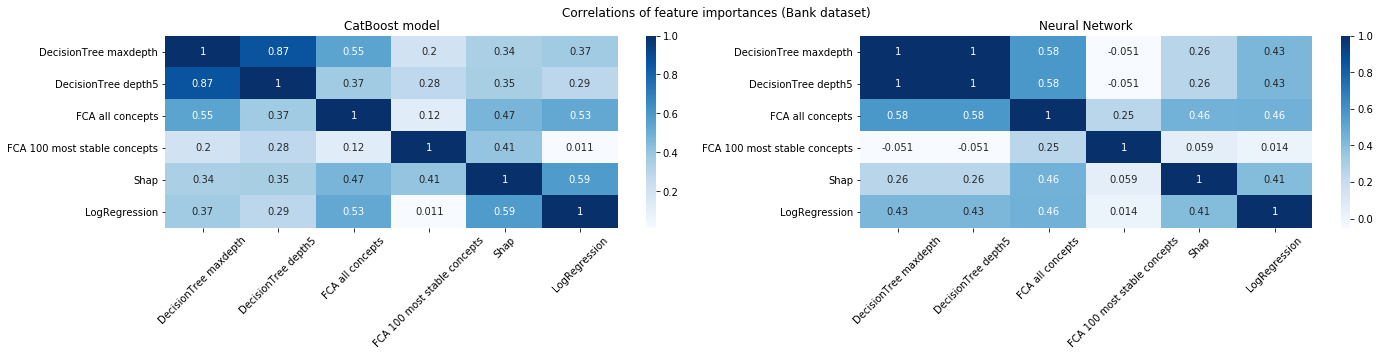

In [995]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.heatmap(cds1, cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.title('CatBoost model')
plt.ylabel('')
plt.xlabel('')

plt.subplot(1,2,2)
sns.heatmap(cds2, cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.title('Neural Network')
plt.ylabel('')
plt.xlabel('')

plt.suptitle('Correlations of feature importances (Bank dataset)')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

In [76]:
fm.calc_stability_approx()

/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:730: RuntimeWarning:

overflow encountered in power



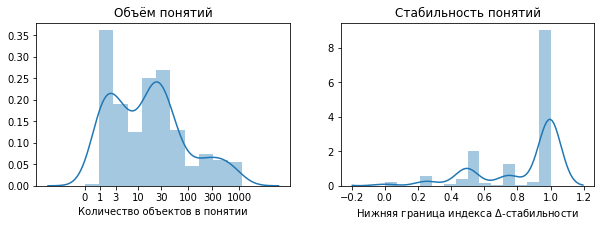

In [91]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.distplot(np.log1p([len(c.get_extent()) for c in fm.get_concepts()]))
xticks = [0, 1, 3, 10, 30, 100, 300, 1000]
plt.xticks(np.log1p(xticks), xticks)
plt.title('Объём понятий')
plt.xlabel('Количество объектов в понятии')

plt.subplot(1,2,2)
sns.distplot([c._metrics['stab_min_bound'] for c in fm.get_concepts() if c._metrics['stab_min_bound'] is not None])
plt.title('Стабильность понятий')
plt.xlabel(r'Нижняя граница индекса $\Delta$-стабильности')
plt.show()

In [638]:
g = '3819'

In [639]:
ds.loc[g]

age                  46
job          technician
marital        divorced
education     secondary
default               0
balance            -824
housing               1
loan                  0
contact        cellular
day                   7
month               aug
duration            429
campaign              3
pdays               NaN
previous              0
poutcome        unknown
y                     1
preds                 0
Name: 3819, dtype: object

In [640]:
preds_ds.loc[g]

preds_cb     0
preds_svc    0
preds_nn     0
Name: 3819, dtype: int64

In [641]:
lr = LogisticRegression()
lr.fit(ds_ohe_norm.loc[test_idxs], preds_ds.loc[test_idxs, 'preds_nn'])
preds_test_real = lr.predict(ds_ohe_norm.loc[test_idxs])
accuracy_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real), f1_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real)

(0.9964633068081344, 0.0)

In [642]:
dt_small = DecisionTreeClassifier(max_depth=5)
dt_small.fit(ds_ohe.loc[test_idxs], preds_ds.loc[test_idxs,'preds_nn'])
preds_test_real = dt_small.predict(ds_ohe.loc[test_idxs])
accuracy_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real), f1_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real)

(1.0, 1.0)

In [643]:
dt_large = DecisionTreeClassifier()
dt_large.fit(ds_ohe.loc[test_idxs], preds_ds.loc[test_idxs,'preds_nn'])
preds_test_real = dt_large.predict(ds_ohe.loc[test_idxs])
accuracy_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real), f1_score(preds_ds.loc[test_idxs,'preds_nn'], preds_test_real)

(1.0, 1.0)

In [644]:
lr.coef_.shape

(1, 77)

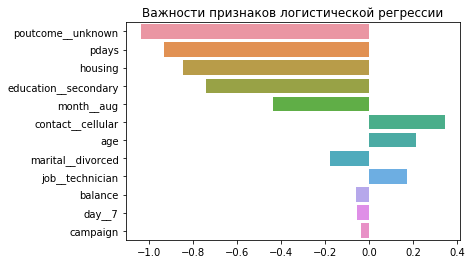

In [645]:
s = pd.Series(lr.coef_[0], index=ds_ohe_norm.columns)[ds_ohe_norm.columns[ds_ohe_norm.loc[g]!=0]]
s = s[s.abs().rank().sort_values(ascending=False).index]
sns.barplot(y=s.index, x=s.values)
plt.title('Важности признаков логистической регрессии')
plt.show()

In [597]:
def get_decisions(estimator, X_test, col_names):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
    node_indicator = estimator.decision_path(X_test)

    leave_id = estimator.apply(X_test)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    # HERE IS WHAT YOU WANT
    sample_id = 0
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:

        if leave_id[sample_id] == node_id:  # <-- changed != to ==
            #continue # <-- comment out
            print("leaf node {} reached, no decision here".format(leave_id[sample_id])) # <--

        else: # < -- added else to iterate through decision nodes
            if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            print("decision id node %s : (%s (= %s) %s %s)"
                  % (node_id,
                     col_names[feature[node_id]],
                     X_test[sample_id, feature[node_id]], # <-- changed i to sample_id
                     threshold_sign,
                     threshold[node_id]))

In [661]:
dt_small.predict_proba(ds_ohe.loc[[g]])

array([[1., 0.]])

In [646]:
get_decisions(dt_small, ds_ohe.loc[[g]].values, ds_ohe_norm.columns)

Rules used to predict sample 0: 
decision id node 0 : (month__mar (= 0.0) <= 0.5)
decision id node 1 : (month__sep (= 0.0) <= 0.5)
decision id node 2 : (age (= 46.0) <= 70.0)
leaf node 3 reached, no decision here


In [662]:
get_decisions(dt_large, ds_ohe.loc[[g]].values, ds_ohe_norm.columns)

Rules used to predict sample 0: 
decision id node 0 : (month__mar (= 0.0) <= 0.5)
decision id node 1 : (month__sep (= 0.0) <= 0.5)
decision id node 2 : (age (= 46.0) <= 70.0)
leaf node 3 reached, no decision here


In [648]:
stable_concepts = sorted(fm.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-1000))[:100]
strong_stable_concepts = [c for c in stable_concepts if abs(c._metrics['mean_y_preds_nn']-0.5)+0.5>=0.6]
#stable_concepts[0]
len(strong_stable_concepts)

100

In [649]:
max_concepts = sorted([c for c in strong_stable_concepts if g in c.get_extent() and len(c.get_extent())>1], key=lambda c: len(c.get_extent()))
print(len(max_concepts))
for i in range(len(max_concepts)):
    if i>=len(max_concepts):
        break
    c = max_concepts[i]
    max_concepts = [c_ for c_ in max_concepts if c_==c or not c.is_subconcept_of(c_)]
len(max_concepts)

9


5

In [650]:
max_concepts = sorted(max_concepts, key=lambda c: len(c.get_extent()))

In [651]:
for c in max_concepts:
    print(f"объём: {len(c.get_extent())}")
    descr = list(c.get_intent().keys())
    descr_share = [len(mvcntx.get_extent({m:c.get_intent()[m]}))/len(mvcntx.get_objs()) for m in descr]
    descr = np.array(descr)[np.argsort(descr_share)]
    for k in descr:
        v = c.get_intent()[k]
        if len(mvcntx.get_extent({k:v}))/len(mvcntx.get_objs())<1:
            print(f"{k}: {v} (supp: {len(mvcntx.get_extent({k:v}))/len(mvcntx.get_objs()):.2%})")
    print(f"mean prediction: {c._metrics['mean_y_preds_cb']:.2%}")
    print('===')
    print('')

объём: 160
day: ('13', '16', '17', '18', '26', '6', '7', '9') (supp: 29.89%)
balance: (-3313, 1221) (supp: 72.24%)
month: ('aug', 'jul', 'jun', 'may', 'nov', 'oct') (supp: 83.82%)
job: ('admin.', 'blue-collar', 'management', 'retired', 'self-employed', 'services', 'technician') (supp: 87.44%)
age: (28, 65) (supp: 92.40%)
contact: ('cellular', 'unknown') (supp: 92.84%)
poutcome: ('failure', 'unknown') (supp: 93.02%)
campaign: (1, 7) (supp: 95.84%)
education: ('primary', 'secondary', 'tertiary') (supp: 96.11%)
previous: (0, 8) (supp: 99.65%)
mean prediction: 0.00%
===

объём: 432
day: ('1', '11', '15', '16', '18', '22', '23', '26', '28', '29', '3', '30', '31', '4', '5', '6', '7') (supp: 56.23%)
job: ('admin.', 'blue-collar', 'entrepreneur', 'management', 'retired', 'student', 'technician', 'unemployed') (supp: 84.35%)
balance: (-824, 3904) (supp: 89.39%)
education: ('primary', 'secondary', 'tertiary') (supp: 96.11%)
campaign: (1, 8) (supp: 97.17%)
month: ('apr', 'aug', 'feb', 'jan', 'jul

In [538]:
import shap

In [652]:
shap.initjs()

In [653]:
shap_expl = shap.DeepExplainer(model, ds_ohe_norm.values)

In [654]:
sv = shap_expl.shap_values(ds_ohe_norm.loc[[g]].values,)[0]

In [655]:
float(shap_expl.expected_value)

0.2928539514541626

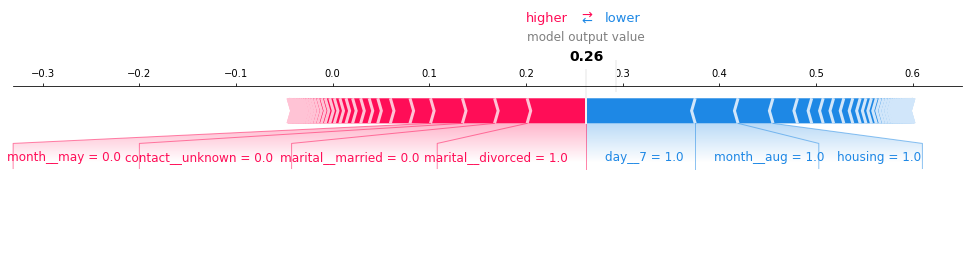

In [663]:
shap.force_plot(float(shap_expl.expected_value), sv, ds_ohe_norm.loc[g].values, ds_ohe_norm.columns,  figsize=(17,3), matplotlib=True, )

In [657]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(ds_ohe_norm.values, #training_labels=preds_ds['preds_nn'].values,
                    feature_names=list(ds_ohe_norm.columns),
                    class_names=['refuse','buy'], 
                    # categorical_features=, 
                    # There is no categorical features in this example, otherwise specify them.                               
                    verbose=True, mode='classification', random_state=42)

In [658]:
def f_(X):
    #return model.predict_proba(X)[0]
    x_ = model.predict_proba(X)
    y_ = np.concatenate([1-x_, x_],1)
    return y_
    #return model.predict(X)[0]

Intercept 1.170243354835977
Prediction_local [0.31869021]
Right: 0.26230878


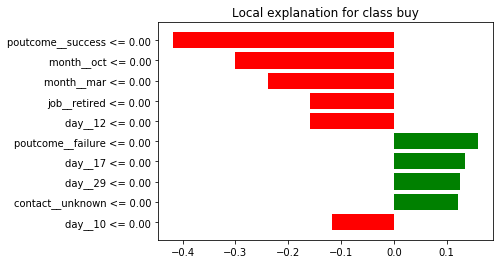

In [659]:
exp = explainer.explain_instance(ds_ohe_norm.loc[[g]].values[0], f_, )# model.predict_proba)
exp.as_pyplot_figure(1)
plt.show()